In [1]:
import glob 
import os
import pandas as pd
import statsmodels as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from importlib import reload
from sklearn import model_selection, metrics
from tqdm.auto import tqdm
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from src import main, feature_model

In [2]:
fp = np.random.choice(glob.glob('../beat_pd/data/cis-pd/training_data/training_samples/*/*.csv'))

In [25]:
import os
# os.path.normpath("~")

'~'

# Working off of Yidi's code, just grab and do some quick analysis
Wanna look over labels, will start off with CIS-PD dataset for now and see what frequency distribution looks like

In [10]:
labels1 = pd.read_csv('data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv')
labels2 = pd.read_csv('data/real-pd/data_labels/REAL-PD_Training_Data_IDs_Labels.csv')

In [11]:
labels = labels1.dropna()

([<matplotlib.axis.XTick at 0x7fdbd50bcb70>,
 <a list of 4 Text xticklabel objects>)

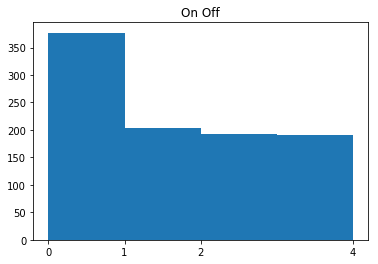

In [5]:
plt.title("On Off")
plt.hist(labels.on_off, bins=4, )
plt.xticks([0,1,2,4])

([<matplotlib.axis.XTick at 0x7fdbd4ff0f28>,
 <a list of 4 Text xticklabel objects>)

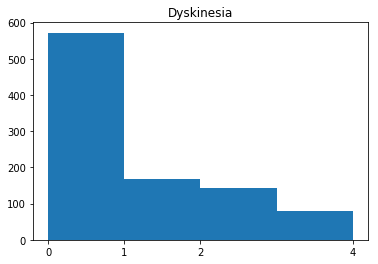

In [6]:
plt.title("Dyskinesia")
plt.hist(labels.dyskinesia, bins=4)
plt.xticks([0,1,2,4])

([<matplotlib.axis.XTick at 0x7fdbd4f53b70>,
 <a list of 4 Text xticklabel objects>)

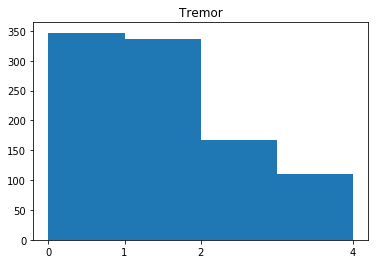

In [7]:
plt.title("Tremor")
plt.hist(labels.tremor, bins=4)
plt.xticks([0,1,2,4])

## Frequency Histogram
See a distribution of frequencies for 5 rando 10 minute sessions of the overall, x, y, and z frequencies. These can provide clear indication of which frequencies are the most powerful in a session.

In [8]:
from src.main import read_seq
fp = np.random.choice(glob.glob('../beat_pd/data/cis-pd/training_data/training_samples/*/*.csv'))
df = read_seq(fp)

In [9]:
df = df.set_index(pd.to_timedelta(df.index, unit="s"))

As per yidi, frequency is 50Hz

In [10]:
import numpy as np
def plot_fft_data(data, limits = (1,10)):
    fft_data =np.abs(
                        np.fft.fft(
                            data,
                            axis=0))
    fft_freq = np.fft.fftfreq(data.shape[0], d=1/50)
    plt.plot(fft_freq, fft_data, "*")
    plt.xlim(limits)
    plt.ylim(0,3)

Text(0, 0.5, 'z axis')

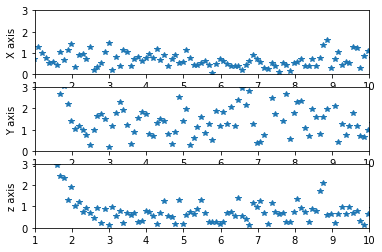

In [11]:
plt.subplot(3,1,1)
plot_fft_data(df.x)
plt.ylabel("X axis")
plt.subplot(3,1,2)
plot_fft_data(df.y)
plt.ylabel("Y axis")
plt.subplot(3,1,3)
plot_fft_data(df.z)
plt.ylabel("z axis")

In [12]:
total_magnitude = df.x **2 + df.y **2 + df.z **2 

Text(0, 0.5, 'z axis')

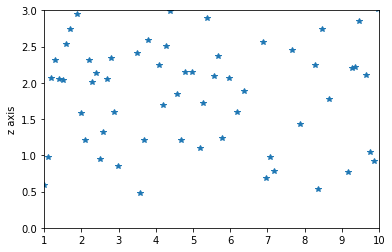

In [13]:
plot_fft_data(total_magnitude)
# plt.ylim((0,10))
plt.ylabel("z axis")

# Quick model

Let's go ahead and try setting up a quick model for testing some stuff with some spur of the moment features. We should eventually decide on a better train_test_split then just random and can eventually use CV partitions or something,  but this should be fine for now. Main goal is create a quick model with some rando quick features

## Files in  CIS-PD
Let's start with CIS-PD, i got confused by training_samples folder, but will be using the 20 minute segments in the first sublevel of the directory

In [24]:
labels1.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [25]:
labels = labels1.dropna() #drop the nans for now, we can worry later

In [27]:
#let's see the distribution of subjects too, as expected its the set of subjects which we have complete data for
labels.groupby("subject_id").count()

,measurement_id,on_off,dyskinesia,tremor
subject_id,,,,
1004,82,82,82,82
1007,276,276,276,276
1019,45,45,45,45
1023,106,106,106,106
1034,40,40,40,40
1038,207,207,207,207
1043,34,34,34,34
1048,91,91,91,91
1049,82,82,82,82


In [39]:
from src.main import read_seq

def get_data(m_id):
    data = pd.read_csv(f"/home/ms994/beat_pd/data/cis-pd/training_data/{m_id}.csv", index_col="Timestamp", header=0)
    return data.set_index(pd.to_timedelta(data.index, unit="s"))

Set up filters. We can adjust these eventually, but tbh don't really care too much about filter design rn

In [56]:
#lets go and filter data with some utility funcs
from scipy.signal import butter, lfilter

# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

# grabs some filter constants for making bandpass filter
#    order is kinda like strength of filter... higher leads to more ideal filter but has weird interactions near the edges of the filter
#    lower is less ideal but results in less artifacts being generated
#    this is a bit of a cheat anyways, using a lowpass and highpass together, there may be less sketch filter designs applicable
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
def butter_lp_filter(data, lowcut, fs, order=5):
    nyq = 0.5 * fs #just get the highest freq possible (nyquist, and bandgap it!)
    hc = nyq * 0.9 #can't accept exactly nyq
    print("hc:", hc)
    return butter_bandpass_filter(data, lowcut, hyc, fs, order)
def butter_bandgap_filter(data, lowcut, highcut, fs, order=5):
    if highcut is None:
        return butter_bandgap_filter(data, lowcut, fs, order)
    toRemove = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    return data - toRemove

Set up functions to apply STFFT

In [144]:
def get_preprocessed_data(measurement_id, low_f=1, high_f=10):
    data = get_data(measurement_id)
    #50 hz, make a bandpass between 1 and 10 hz, with order of 5
    data = butter_bandpass_filter(data, low_f, high_f, 50, 5)
    return data

In [165]:
def stft(measurement_id, use_filter=True):
    if use_filter:
        data = get_preprocessed_data(measurement_id)
    else:
        data = get_data(measurement_id)
    return np.abs(signal.stft(data.T, fs=50, window=("boxcar"), nperseg=50))

In [94]:
labels.measurement_id.iloc[0]

'cc7b822c-e310-46f0-a8ea-98c95fdb67a1'

In [136]:
data = get_data(labels.measurement_id.iloc[0])

In [130]:
labels.measurement_id.iloc[0]

'cc7b822c-e310-46f0-a8ea-98c95fdb67a1'

In [137]:

stft_res = stft("cc7b822c-e310-46f0-a8ea-98c95fdb67a1", use_filter=False)
stft_res[2].shape

(3, 51, 900)

0.005896983026686894

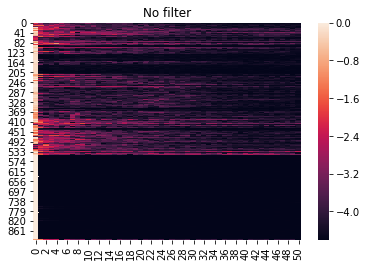

In [138]:
import seaborn as sns
plt.title("No filter")
stft_res = stft("cc7b822c-e310-46f0-a8ea-98c95fdb67a1", use_filter=False)
sns.heatmap(np.log(stft_res[2][2].transpose((1,0)) + 0.01))

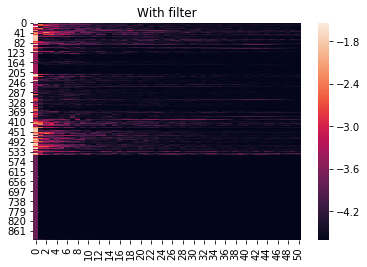

In [140]:
plt.title("With filter")
stft_res = stft("cc7b822c-e310-46f0-a8ea-98c95fdb67a1", use_filter=True)
sns.heatmap(np.log(stft_res[2][2].transpose((1,0)) + 0.01))

Some observations from the spectograph, the signal strength kinda dies after 533 samples, in addition, strength of the signal appears to increase for lower frequencies, as expected from the overal distribution of frequencies

filtering seems to reduce the overal amplitudes in the signal. 

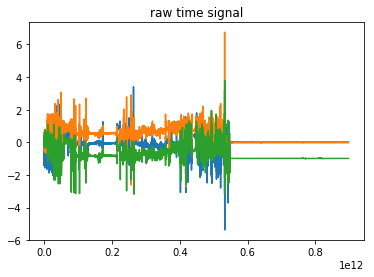

In [142]:
plt.title("raw time signal")
plt.plot(data)

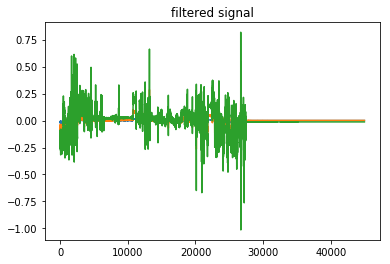

In [145]:
plt.title("filtered signal, 0-10 Hz")
plt.plot(get_preprocessed_data(labels.measurement_id[0]))

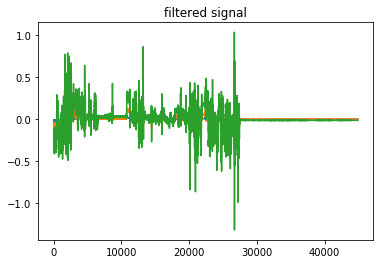

In [146]:
plt.title("filtered signal, 0.5 to 10 hz")
plt.plot(get_preprocessed_data(labels.measurement_id[0], low_f=0.5))

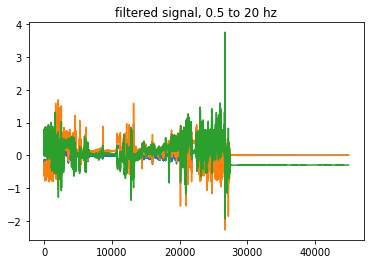

In [149]:
plt.title("filtered signal, 0.5 to 20 hz")
plt.plot(get_preprocessed_data(labels.measurement_id[0], low_f=1, high_f=20))

as per literature, tremors and diskinesia should show up in only the 4 ot 6 Hz range. Don't know if these higher freqency signals are useful or just noise, will continue with 1-10 Hz bandpass

In [150]:
from sklearn.decomposition import PCA

In [152]:
stft_res[2].shape, labels.shape

((3, 51, 900), (963, 5))

In [158]:
xData = []

In [166]:
for i in range(963):
    xData.append(stft(labels.measurement_id.iloc[i], use_filter=True)[2])

In [167]:
len(xData)

2008

In [168]:
#dangit, these are all different shapes. gonna split appart into 1 minute (50 sample) instances
[xDatum.shape[2] for xDatum in xData]

[900,
 1198,
 1198,
 1202,
 1201,
 1207,
 1205,
 1203,
 1203,
 1203,
 1201,
 1200,
 1205,
 1201,
 1202,
 1209,
 1202,
 1201,
 1201,
 155,
 1212,
 1205,
 1199,
 1201,
 1201,
 1200,
 1201,
 1203,
 1203,
 1200,
 1204,
 1204,
 1229,
 1200,
 1202,
 1202,
 1205,
 1201,
 1200,
 1202,
 1200,
 1200,
 1233,
 1223,
 321,
 1203,
 1204,
 1201,
 1212,
 1203,
 1201,
 1204,
 1204,
 603,
 1201,
 1230,
 1214,
 1202,
 1211,
 1202,
 1201,
 250,
 781,
 1201,
 1223,
 1219,
 939,
 810,
 1202,
 1201,
 1201,
 1205,
 139,
 1063,
 1201,
 1203,
 1200,
 1201,
 1201,
 1202,
 1008,
 1203,
 900,
 1198,
 1198,
 1202,
 1201,
 1207,
 1205,
 1203,
 1203,
 1203,
 1201,
 1200,
 1205,
 1201,
 1202,
 1209,
 1202,
 1201,
 1201,
 155,
 1212,
 1205,
 1199,
 1201,
 1201,
 1200,
 1201,
 1203,
 1203,
 1200,
 1204,
 1204,
 1229,
 1200,
 1202,
 1202,
 1205,
 1201,
 1200,
 1202,
 1200,
 1200,
 1233,
 1223,
 321,
 1203,
 1204,
 1201,
 1212,
 1203,
 1201,
 1204,
 1204,
 603,
 1201,
 1230,
 1214,
 1202,
 1211,
 1202,
 1201,
 250,
 781,


In [170]:
xData[0].shape # x,y,z channel, frequency, time window

(3, 51, 900)

In [171]:
xData = []
for i in range(len(labels)):
    xData.append(stft(labels.measurement_id.iloc[i], use_filter=True)[2].transpose(2, 0, 1)) #put the time window first 

In [174]:
np_x_data = np.vstack(xData)

In [176]:
import pickle as pkl
pkl.dump(np_x_data, open("/n/scratch2/ms994/beat_pd_frequency_data.pkl", "wb"))

In [177]:
np_x_data.shape

(2210912, 3, 26)

In [178]:
flattened_x = np_x_data.reshape((-1, 3*26))

In [180]:
from sklearn.decomposition import PCA

In [190]:
pca = PCA()
pca.fit(flattened_x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 78 artists>

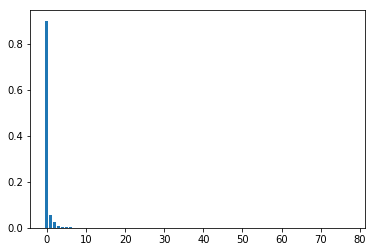

In [186]:
plt.bar(x=[i for i in range(3*26)], height=pca.explained_variance_ratio_)

In [192]:
pca = PCA(10)
pca_feats = pca.fit_transform(flattened_x)

appears all variance without log transform is capturwed in first few PCA features

In [194]:
pca_feats.shape #less features, wanna just do this quick

(2210912, 10)

### Setup  the labels
Since i happened to flatten and concatenate all the variable lenght segments, i have to map the labels to each instance
i.e. if we had a 900s file that got split into 900 windows of 10 features each, each get the same label

In [198]:
all_x_lengths = [xDatum.shape[0] for xDatum in xData]

In [200]:
#theres probs some faster way with vectorized operations, but idc
y = []
for i in range(len(labels)):
    for x_len in range(all_x_lengths[i]):
        y.append(labels.iloc[i])

In [201]:
len(y) == len(pca_feats)

True

In [209]:
y = pd.concat(y, axis=1)

In [210]:
y.head() #wtf >:#

,0,0,0,0,0,0,0,0,0,0,...,1663,1663,1663,1663,1663,1663,1663,1663,1663,1663
measurement_id,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,...,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027,8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027
subject_id,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004,...,1049,1049,1049,1049,1049,1049,1049,1049,1049,1049
on_off,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
dyskinesia,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tremor,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2


In [211]:
y.T.head() #much better :D

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1


In [212]:
pkl.dump(y.T, open("/n/scratch2/ms994/beat_pd_labels_1s.pkl", "wb"))

In [214]:
y = y.T

## load stored pkl data

In [2]:
import pickle as pkl
np_x_data = pkl.load(open("/n/scratch2/ms994/beat_pd_frequency_data.pkl", "rb"))


In [3]:
y = pkl.load(open("/n/scratch2/ms994/beat_pd_labels_1s.pkl", "rb"))

## let's make a quick RF model

In [217]:
linReg = sklearn.linear_model.LinearRegression()
y_on_off = y.on_off
x = pca_feats

In [218]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_on_off)

In [220]:
linReg = linReg.fit(x_train, y_train)

In [221]:
y_pred = linReg.predict(x_test)

In [223]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, y_pred) #bit bad on a 4 point scale

1.7136879963985014

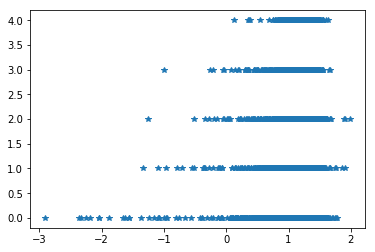

In [225]:
plt.plot(y_pred, y_test, "*") # looks like a mess, some predictions at -3, never goes to 4

In [ ]:
plt.plot(y_pred + , y_test, "*") # looks like a mess, some predictions at -3, never goes to 4

In [234]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100, max_features=0.33, oob_score=True, n_jobs=4)
rf = rf.fit(x_train, y_train.values.astype(int))
y_pred = rf.predict(x_test)
score = mse(y_pred, y_test)

In [236]:
score #holy cow this is worst

2.2442557641371526

In [243]:
len(y_test)

552728

In [253]:
y_test_jitter = y_test + np.random.random(len(y_test))*0.2 #add some jitter to show off data
y_pred_jitter = y_pred + np.random.random(len(y_test))*0.2 #add some jitter to show off data

subindex = np.random.choice(len(y_test), 52728, replace=False)

In [252]:
len(y_test_jitter), len(y_pred), len(subindex)

(552728, 552728, 52728)

In [258]:
y_test_jitter[0]

0     1.0943
0    1.05754
0    1.07146
0    1.11057
0    1.18453
0    1.01304
0    1.19432
0    1.05007
0    1.10559
0    1.18236
0    1.13693
0      1.127
0    1.03009
0    1.05123
0    1.10678
0    1.14978
0    1.01541
0    1.16645
0    1.17752
0     1.0157
0    1.02633
0    1.02148
0      1.095
0    1.00396
0     1.1832
0    1.04287
0    1.04043
0    1.18253
0     1.0765
0    1.04985
      ...   
0    1.06134
0    1.09462
0    1.04022
0     1.0566
0    1.10887
0    1.15293
0    1.10003
0    1.09139
0    1.12064
0    1.14518
0    1.19359
0    1.19322
0    1.14302
0    1.09356
0    1.00357
0    1.03201
0    1.13716
0    1.17981
0     1.0651
0    1.05057
0    1.06026
0    1.01549
0    1.00514
0    1.14774
0    1.12572
0    1.04301
0    1.19912
0    1.08313
0    1.12101
0    1.03324
Name: on_off, Length: 513, dtype: object

ValueError: x and y must have same first dimension, but have shapes (111995,) and (52728,)

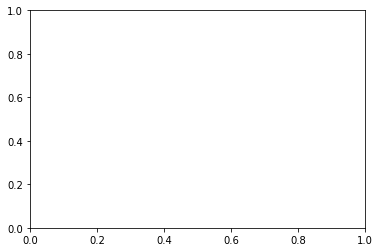

In [254]:
plt.plot(y_test_jitter[subindex], y_pred_jitter[subindex], "*")

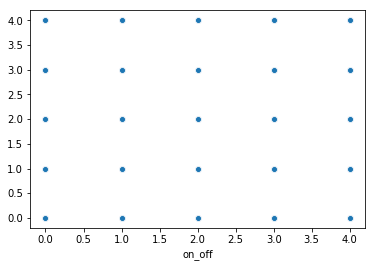

In [240]:
sns.scatterplot(y_test, y_pred, x_jitter=0.3, y_jitter=0.3)

In [228]:
from sklearn.ensemble import RandomForestClassifier
#rf doesnt need cv, use the OOB
all_rf = []
for i in range(1, 21, 5):
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators=10*i, max_features=0.33, oob_score=True, n_jobs=4)
    rf = rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    score = mse(y_pred, y_test)
    all_rf.append({"pred": rf, "y_pred": y_pred, "oob_score": rf.})

### try some more data cleaning
let's try looking at and removing data between 1 and 99th percentile

In [4]:
flatten_x = np_x_data.reshape((-1, 3*26))

(array([2.06100e+06, 1.45267e+05, 3.26700e+03, 6.18000e+02, 3.79000e+02,
        2.20000e+02, 1.03000e+02, 4.10000e+01, 1.50000e+01, 2.00000e+00]),
 array([2.45866013e-05, 5.12555806e-03, 1.02265295e-02, 1.53275010e-02,
        2.04284724e-02, 2.55294439e-02, 3.06304153e-02, 3.57313868e-02,
        4.08323583e-02, 4.59333297e-02, 5.10343012e-02]),
 <a list of 10 Patch objects>)

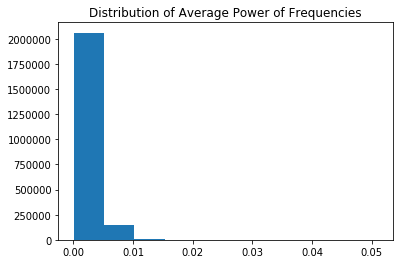

In [5]:
plt.title("Distribution of Average Power of Frequencies")
plt.hist(flatten_x.mean(axis=1)) 

In [6]:
average_freq_pow = flatten_x.mean(axis=1)

In [7]:
np.mean(average_freq_pow > 0.02) #less than 0.0003 of the data has such a high power

0.0003609370250828617

In [8]:
filtered_x = flatten_x[average_freq_pow < 0.02]

In [12]:
labels.shape

(963, 5)

In [13]:
y_filter = y[average_freq_pow < 0.02]

(array([7.21225e+05, 6.23237e+05, 4.08854e+05, 4.04686e+05, 5.13650e+04,
        6.06000e+02, 1.02000e+02, 2.50000e+01, 9.00000e+00, 5.00000e+00]),
 array([7.40259681e-05, 6.41768071e-03, 1.27613355e-02, 1.91049902e-02,
        2.54486449e-02, 3.17922997e-02, 3.81359544e-02, 4.44796092e-02,
        5.08232639e-02, 5.71669187e-02, 6.35105734e-02]),
 <a list of 10 Patch objects>)

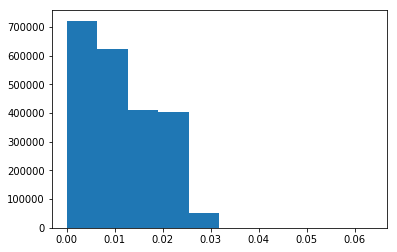

In [14]:
plt.hist(filtered_x.std(axis=1)) 

Some really noisy segments at or above 0.3. what percentage of seconds have that?

In [15]:
np.mean(filtered_x.std(axis=1) > 0.04) #don't care, just take it off

4.117434666266084e-05

(array([3.55000e+02, 2.35900e+03, 1.09130e+04, 5.98870e+04, 2.01587e+05,
        4.62867e+05, 6.05599e+05, 7.32361e+05, 1.30344e+05, 3.84200e+03]),
 array([-6.2566001 , -5.58648238, -4.91636467, -4.24624695, -3.57612923,
        -2.90601152, -2.2358938 , -1.56577608, -0.89565837, -0.22554065,
         0.44457707]),
 <a list of 10 Patch objects>)

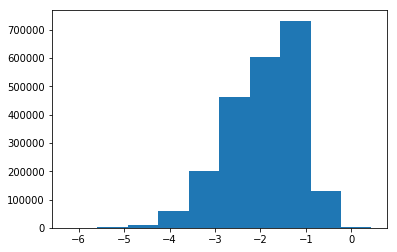

In [16]:
plt.hist(np.log(filtered_x.sum(axis=1))) #some of the samples are likely no activity segments (when the person takes off the sensor)

In [17]:
y_filter = y_filter[filtered_x.std(axis=1) < 0.04]

In [18]:
filtered_x = filtered_x[filtered_x.std(axis=1) < 0.04]

In [19]:
y_filter = y_filter[np.log(filtered_x.sum(axis=1)) > -4]
filtered_x = filtered_x[np.log(filtered_x.sum(axis=1)) > -4]

In [20]:
(flatten_x.shape[0] - filtered_x.shape[0])/flatten_x.shape[0] #removed approximately 0.001 of the data

0.016581392656062295

In [24]:
filtered_x.shape

(2174252, 78)

In [25]:
from sklearn.decomposition import PCA
pca = PCA()
pca = pca.fit(filtered_x)

<BarContainer object of 78 artists>

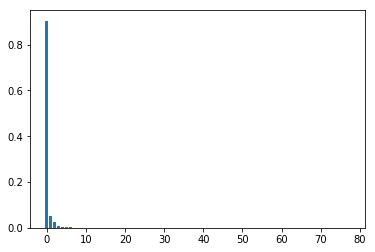

In [26]:
plt.bar(x=[i for i in range(3*26 )], height=pca.explained_variance_ratio_)

<BarContainer object of 77 artists>

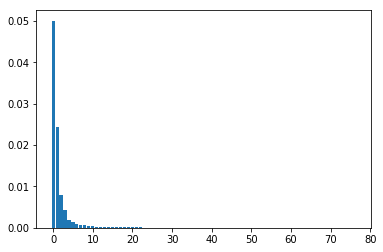

In [27]:
plt.bar(x=[i for i in range(3*26 - 1)], height=pca.explained_variance_ratio_[1:])

In [28]:
pca_feats = pca.fit_transform(filtered_x)

In [29]:
pca_feats.shape, y_filter.shape

((2174252, 78), (2174252, 5))

In [30]:
y_filter.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1,1,1


## let's do a quick lin reg again

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [33]:
linReg = LinearRegression()
#use the features that capture all of the variance
x_train, x_test, y_train, y_test = train_test_split(pca_feats[:,0:20], y_filter)


In [36]:
y_train.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
56,e49db734-9ccf-4581-ae15-cbda39262bbf,1004,0,0,0
1635,28fa7e74-ba03-46bc-b6da-88261da5086d,1049,1,1,2
756,8e8539ad-8841-476b-b15c-888ce3461989,1023,0,0,0
256,61ffc084-9e6e-49f2-b235-8c6cf1bc2bae,1007,1,0,1
334,b91a582c-d54d-4975-b2bd-15f2c194a4b8,1007,0,0,1


In [37]:
linReg = linReg.fit(x_train, y_train.on_off.astype(int))

In [39]:
from sklearn.metrics import mean_squared_error as mse
mse(y_train.on_off.astype(int), linReg.predict(x_train)) 

1.720068106058182

In [40]:
mse(y_test.on_off.astype(int), linReg.predict(x_test)) #lel, still as bad

1.7229724057105518

In [42]:
#but what if i take the average over all measurements?
y_pred = linReg.predict(x_test)

In [50]:
y_test.loc[:,"pred"] = y_pred
y_test.loc[:, "on_off"] = y_test.on_off.astype(int)

In [53]:
intermediate = y_test.groupby("measurement_id")["pred", "on_off"].mean()
mse(intermediate.pred.values, intermediate.on_off.values) #yuck, it regresses towards the mean

1.7109337454141693

In [55]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
rf = rf.fit(x_train, y_train.on_off.astype(int))
y_pred = rf.predict(x_test)
print(rf.oob_score_)

0.5398975525069465


In [58]:
y_train_pred =  rf.predict(x_train)

In [60]:
y_train_pred.shape, y_test.on_off.astype(int).shape

((1630689,), (543563,))

In [63]:
print(mse(y_train.on_off.astype(int), y_train_pred)) #at least we overfit

0.0


In [73]:
y_pred = rf.predict_proba(x_test)

In [75]:
y_pred.shape

(543563, 5)

In [76]:
y_pred = pd.DataFrame(y_pred, columns=[0,1,2,3,4])

In [87]:
y_pred.loc[:,"m_id"] = y_test.reset_index().measurement_id

In [110]:
y_pred_true = y_pred.set_index("m_id").join(y_test.groupby("measurement_id").mean().on_off.astype(int))

In [120]:
y_pred_true = y_pred_true.reset_index().groupby("index").mean()

In [131]:
print(mse(y_pred_true.on_off.values, y_pred_true[[0,1,2,3,4]].values.argmax(1))) #damn it

2.127725856697819


In [91]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, oob_score=True, n_jobs=4)
rf = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
score = mse(y_pred, y_test)

/home/ms994/miniconda3/envs/keras-redo-cpu/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ms994/miniconda3/envs/keras-redo-cpu/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/ms994/miniconda3/envs/keras-redo-cpu/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [94]:
rf.oob_score_

0.4586901610300922

In [92]:
score

2.2506756346550447


In [ ]:
from sklearn.ensemble import RandomForestClassifier
all_rf = []
from tqdm import tqdm
for i in tqdm(range(8, 40, 8)):
    rf = RandomForestClassifier(n_estimators=i*5, oob_score=True, n_jobs=4)
    rf = rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    score = mse(y_pred, y_test)
    all_rf.append((rf, y_pred, score))



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [03:15<09:47, 195.90s/it]

In [102]:
all_rf[0][0].oob_score_

0.5166319267499812

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=4)
rf = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
score = mse(y_pred, y_test)

## the files in training_samples
I'm confused by the files in the training samples subfolders. None of these seem to be standardized to a common time. Are these some preprocessed data segment or were they originally part of the dataset?

In [14]:
import glob
all_csv = glob.glob(f"/home/hy180/projects/beat_pd/data/cis-pd/training_data/training_samples/*/*.csv")

In [15]:
m_id =  [csv_file.split("/")[9] for csv_file in all_csv]
file_map= pd.DataFrame([all_csv, m_id]).T

In [16]:
labels.loc[:,"measurement_id"] = labels.measurement_id.astype("str") #some weird dtype issue, this is a string

/home/ms994/miniconda3/envs/keras-redo-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
file_map.columns = ["fp", "measurement_id"]
# file_map = file_map.set_index("measurement_id")

In [18]:
labels.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,cc7b822c-e310-46f0-a8ea-98c95fdb67a1,1004,1.0,1.0,1.0
1,5163afe8-a6b0-4ea4-b2ba-9b4501dd5912,1004,0.0,0.0,0.0
2,5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a,1004,1.0,1.0,1.0
3,fb188ae2-2173-4137-9236-19a137a402c2,1004,3.0,3.0,3.0
4,19a3e9ea-fce1-40b7-9457-2618970beb7b,1004,1.0,1.0,1.0


In [19]:
indexData = file_map.join(labels.set_index("measurement_id"), how="inner", on="measurement_id")

In [20]:
labels1.shape

(1858, 5)

We created an index mapping individual files to a label

In [21]:
indexData.head()

,fp,measurement_id,subject_id,on_off,dyskinesia,tremor
0,/home/hy180/projects/beat_pd/data/cis-pd/train...,ab9052a1-97f0-4ac2-8806-e55e38ece033,1049,1.0,0.0,1.0
1,/home/hy180/projects/beat_pd/data/cis-pd/train...,ab9052a1-97f0-4ac2-8806-e55e38ece033,1049,1.0,0.0,1.0
2,/home/hy180/projects/beat_pd/data/cis-pd/train...,ab9052a1-97f0-4ac2-8806-e55e38ece033,1049,1.0,0.0,1.0
3,/home/hy180/projects/beat_pd/data/cis-pd/train...,ab9052a1-97f0-4ac2-8806-e55e38ece033,1049,1.0,0.0,1.0
4,/home/hy180/projects/beat_pd/data/cis-pd/train...,ab9052a1-97f0-4ac2-8806-e55e38ece033,1049,1.0,0.0,1.0


In [23]:
indexData.shape

(12180, 6)

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(indexData.index, test_size=0.2)

In [62]:
train, valid = train_test_split(train, test_size=0.2)

In [63]:
len(train), len(valid), len(test)

(616, 154, 193)

Setup code to read each label here and return a dataframe

In [150]:
from src.main import read_seq

def get_data(fp):
    return read_seq(fp)

In [156]:
indexData.fp[0]

'/home/hy180/projects/beat_pd/data/cis-pd/training_data/training_samples/ab9052a1-97f0-4ac2-8806-e55e38ece033/9.csv'

In [155]:
pd.read_csv(indexData.fp[0])

,t,x,y,z
